# Hidden Markov Models and Viterbi algorithm for Part-of-Speech tagging

This is a tutorial designed to showcase the usage of Hidden Markov Models (HMMs) for Part-of-Speech (POS) tagging, using the Viterbi algorithm. An illustrative explanatory example video can be found here: https://www.youtube.com/watch?v=Lj4NKxg0xa0 . We encourage you to start with reviewing the course materials on HMMs, then watch the video, then go through this tutorial and finally go back to the HMM lab, but all of these resources can also be consulted independently. 


In this tutorial, we will show you how to do POS-tagging using the Viterbi algorithm. The data we will work with is the tagged Treebank corpus, available in `nltk`. The structure of this tutorial is the following: 
1. We will download the data and explore its contents and structure, then split it into test and train subsets. 
2. We will create a HMM of the tagged dataset. To do so, we will compute the emission probabilities P(observation|state) and the transition probabilities P(state2|state1). 
3. We will apply Viterbi's algorithm to the HMM.
4. We will check the accuracy of our model on the test dataset.

In [2]:
#Importing the libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

# 1. Exploring the Treebank tagged corpus

In [4]:
# Downloading the corpus 
nltk.download('treebank')
wsj = list(nltk.corpus.treebank.tagged_sents())

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\samai\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


We start by looking at the first few tagged sentences.

In [11]:
len(wsj)

3914

In [5]:
print(wsj[:40])

[[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')], [('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')], [('Rudolph', 'NNP'), ('Agnew', 'NNP'), (',', ','), ('55', 'CD'), ('years', 'NNS'), ('old', 'JJ'), ('and', 'CC'), ('former', 'JJ'), ('chairman', 'NN'), ('of', 'IN'), ('Consolidated', 'NNP'), ('Gold', 'NNP'), ('Fields', 'NNP'), ('PLC', 'NNP'), (',', ','), ('was', 'VBD'), ('named', 'VBN'), ('*-1', '-NONE-'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('of', 'IN'), ('this', 'DT'), ('British', 'JJ'), ('industrial', 'JJ'), ('conglomerate', 'NN'), ('.', '.')], [('A', 'DT'), ('f

Then, we split the data into a train and a test set.

In [6]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(wsj,test_size=0.3)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

2739
1175
[[('Mr.', 'NNP'), ('Baum', 'NNP'), (',', ','), ('a', 'DT'), ('seasoned', 'JJ'), ('marketer', 'NN'), ('who', 'WP'), ('*T*-29', '-NONE-'), ('is', 'VBZ'), ('said', 'VBN'), ('*-1', '-NONE-'), ('to', 'TO'), ('have', 'VB'), ('a', 'DT'), ('good', 'JJ'), ('rapport', 'NN'), ('with', 'IN'), ('Campbell', 'NNP'), ('employees', 'NNS'), (',', ','), ('will', 'MD'), ('have', 'VB'), ('responsibility', 'NN'), ('for', 'IN'), ('all', 'DT'), ('domestic', 'JJ'), ('operations', 'NNS'), ('except', 'IN'), ('the', 'DT'), ('Pepperidge', 'NNP'), ('Farm', 'NNP'), ('unit', 'NN'), ('.', '.')], [('The', 'DT'), ('len', 'NN'), ("'s", 'POS'), ('foldability', 'NN'), ('enables', 'VBZ'), ('it', 'PRP'), ('to', 'TO'), ('be', 'VB'), ('inserted', 'VBN'), ('*-1', '-NONE-'), ('in', 'IN'), ('smaller', 'JJR'), ('incisions', 'NNS'), ('than', 'IN'), ('*', '-NONE-'), ('are', 'VBP'), ('now', 'RB'), ('possible', 'JJ'), ('for', 'IN'), ('cataract', 'NN'), ('surgery', 'NN'), (',', ','), ('the', 'DT'), ('eye', 'NN'), ('care', 'NN

The next 5 cells are there to help us explore the corpus and obtain more information about its contents.

In [7]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

70739

In [8]:
# Tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Mr.',
 'Baum',
 ',',
 'a',
 'seasoned',
 'marketer',
 'who',
 '*T*-29',
 'is',
 'said']

In [11]:
# Vocabulary
V = set(tokens)
print(len(V))

10233


In [12]:
# Number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

46

In [13]:
print(T)

{'-RRB-', 'SYM', 'PRP', '$', 'NNS', 'VBP', 'WDT', 'RB', 'MD', 'WP$', 'IN', '-NONE-', '``', 'VBG', ':', '.', 'RBR', 'POS', 'DT', 'EX', 'JJ', 'CD', 'RBS', 'JJR', 'JJS', 'VBD', ',', 'VB', 'WP', 'PDT', "''", '-LRB-', 'VBZ', 'UH', 'FW', 'PRP$', 'LS', 'NN', '#', 'VBN', 'TO', 'NNP', 'NNPS', 'CC', 'WRB', 'RP'}


## 2. POS Tagging algorithm: HMM

We will use a HMM to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word.

In other words, to every word $w$, assign the tag $t$ that maximises the likelihood $P(t|w)$. By Bayes' rule, we have to compute $P(w|t)$ and $P(t)$.
$$
P(w|t) = count(w, t) / count(t).
$$
The term $P(t)$ is the probability of the tag $t$. In this tagging task, as we would like to model the tagging with an HMM, we assume that a tag will depend only on the previous tag. 

Given the PennTreebank tagged dataset, we can compute the two terms $P(w|t)$ and $P(t)$ and store them in two large matrices. The matrix of $P(w|t)$ will be sparse, since each word will not ever be seen with most of the tags, thus making the probability for these pairing to be zero.

First, we compute the emission probabilities.

In [14]:
# Computing P(w|t) and storing them in a T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

print(w_given_t)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
# Emission probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

Let's look at some examples:

In [16]:
# large
print("\n", "large")
print(word_given_tag('large', 'JJ'))
print(word_given_tag('Android', 'NN'))
print(word_given_tag('large', 'VB'))
print(word_given_tag('large', 'NN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'MD'))
print(word_given_tag('will', 'NN'))
print(word_given_tag('will', 'VB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NN'))
print(word_given_tag('book', 'VB'))


 large
(22, 4117)
(0, 9365)
(0, 1791)
(0, 9365) 


 will
(199, 649)
(1, 9365)
(0, 1791)

 book
(7, 9365)
(1, 1791)


Then, we compute the transition probabilities.

In [17]:
# Transition probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1 ,(count_t2_t1/count_t1)*100)

Let's look at some examples:

In [18]:
# examples
print(t2_given_t1(t2='NNP', t1='JJ'))
print(t2_given_t1('NN', 'JJ'))
print(t2_given_t1('NN', 'DT'))
print(t2_given_t1('NNP', 'VB'))
print(t2_given_t1(',', 'NNP'))
print(t2_given_t1('PRP', 'PRP'))
print(t2_given_t1('VBG', 'NNP'))
print(t2_given_t1('VB', 'MD'))

(141, 4117, 3.4248239008987125)
(1865, 4117, 45.299975710468786)
(2739, 5773, 47.445002598302445)
(64, 1791, 3.573422668900056)
(975, 6565, 14.85148514851485)
(3, 1257, 0.23866348448687352)
(5, 6565, 0.07616146230007616)
(530, 649, 81.66409861325116)


Note: $P(tag|start)$ is same as $P(tag|'.')$.

In [19]:
print(t2_given_t1('DT', '.'))
print(t2_given_t1('VBG', '.'))
print(t2_given_t1('NN', '.'))
print(t2_given_t1('NNP', '.'))

(569, 2711, 20.98856510512726)
(12, 2711, 0.4426410918480265)
(100, 2711, 3.6886757654002214)
(494, 2711, 18.222058281077093)


Now, we will store the emission probabilities and the transition probabilities in matrices, to create the HMM.

In [20]:
# Creating the t x t transition matrix of tags:
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]


In [21]:
tags_matrix

array([[0.        , 0.        , 0.02020202, ..., 0.03030303, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00238663, ..., 0.0071599 , 0.        ,
        0.00238663],
       ...,
       [0.0006215 , 0.        , 0.04474829, ..., 0.0006215 , 0.00310752,
        0.        ],
       [0.        , 0.        , 0.14074074, ..., 0.        , 0.        ,
        0.00740741],
       [0.        , 0.        , 0.        , ..., 0.01324503, 0.        ,
        0.        ]], dtype=float32)

Below, we showcase different methods of visualisation, to better see what we are doing.

In [23]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))


In [24]:
tags_df

,-RRB-,SYM,PRP,$,NNS,VBP,WDT,RB,MD,WP$,...,LS,NN,#,VBN,TO,NNP,NNPS,CC,WRB,RP
-RRB-,0.000000,0.000000,0.020202,0.000000,0.000000,0.020202,0.010101,0.060606,0.010101,0.000000,...,0.000000,0.050505,0.000000,0.010101,0.010101,0.040404,0.000000,0.030303,0.000000,0.000000
SYM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
PRP,0.000000,0.000000,0.002387,0.000000,0.001591,0.176611,0.000000,0.049324,0.116945,0.000000,...,0.000000,0.003978,0.000000,0.003978,0.015115,0.002387,0.000000,0.007160,0.000000,0.002387
$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NNS,0.002133,0.000000,0.002133,0.000237,0.010903,0.093150,0.015169,0.024413,0.025836,0.000474,...,0.000000,0.024887,0.000000,0.018488,0.018725,0.000948,0.000000,0.058071,0.002370,0.000474
VBP,0.000000,0.000000,0.023379,0.000000,0.025505,0.000000,0.001063,0.140276,0.000000,0.000000,...,0.000000,0.031881,0.000000,0.162593,0.012752,0.019129,0.000000,0.002125,0.001063,0.009564
WDT,0.000000,0.000000,0.047170,0.000000,0.022013,0.000000,0.000000,0.003145,0.000000,0.000000,...,0.000000,0.009434,0.000000,0.000000,0.000000,0.012579,0.000000,0.000000,0.000000,0.000000
RB,0.000000,0.000000,0.004073,0.008147,0.005092,0.032077,0.001527,0.072811,0.009674,0.000000,...,0.000000,0.015275,0.000000,0.097760,0.016802,0.003564,0.000509,0.007128,0.002037,0.000000
MD,0.000000,0.000000,0.001541,0.000000,0.001541,0.000000,0.000000,0.157165,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
WP$,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
tags_df.loc['.', :]

-RRB-     0.005164
SYM       0.000000
PRP       0.060125
$         0.001475
NNS       0.043158
VBP       0.000000
WDT       0.000000
RB        0.044264
MD        0.000000
WP$       0.000000
IN        0.121357
-NONE-    0.020657
``        0.071191
VBG       0.004426
:         0.002951
.         0.000000
RBR       0.001107
POS       0.000000
DT        0.209886
EX        0.004426
JJ        0.032091
CD        0.006271
RBS       0.000369
JJR       0.001844
JJS       0.001475
VBD       0.000738
,         0.000000
VB        0.000369
WP        0.004058
PDT       0.001107
''        0.061601
-LRB-     0.004795
VBZ       0.002951
UH        0.000369
FW        0.000000
PRP$      0.005164
LS        0.002213
NN        0.036887
#         0.000000
VBN       0.001844
TO        0.001475
NNP       0.182221
NNPS      0.001844
CC        0.053486
WRB       0.006271
RP        0.000000
Name: ., dtype: float32

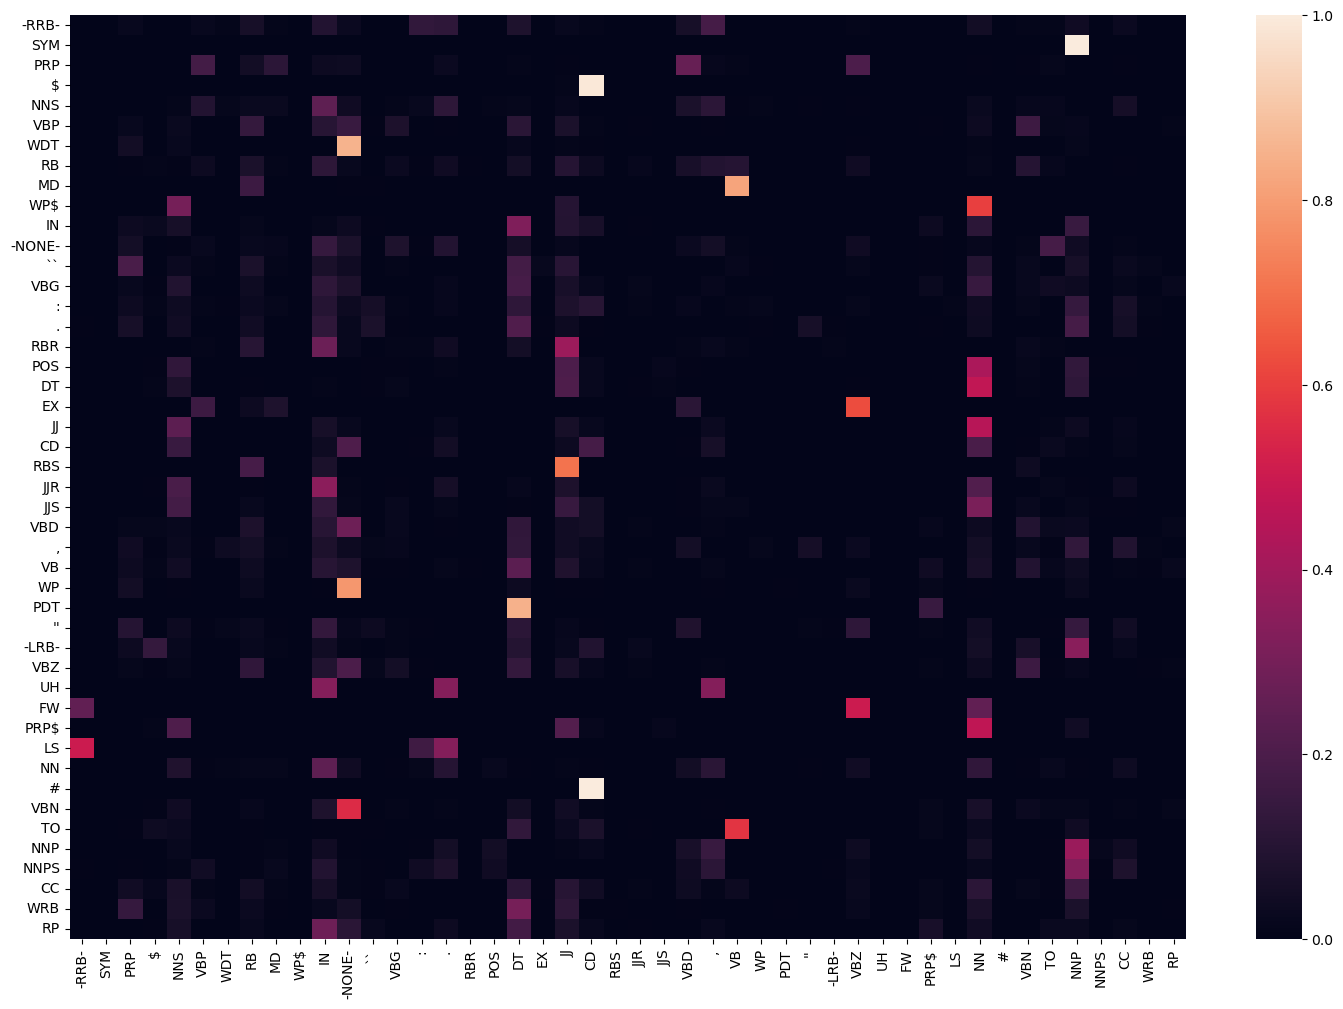

In [27]:
# Heatmap of tags matrix:
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


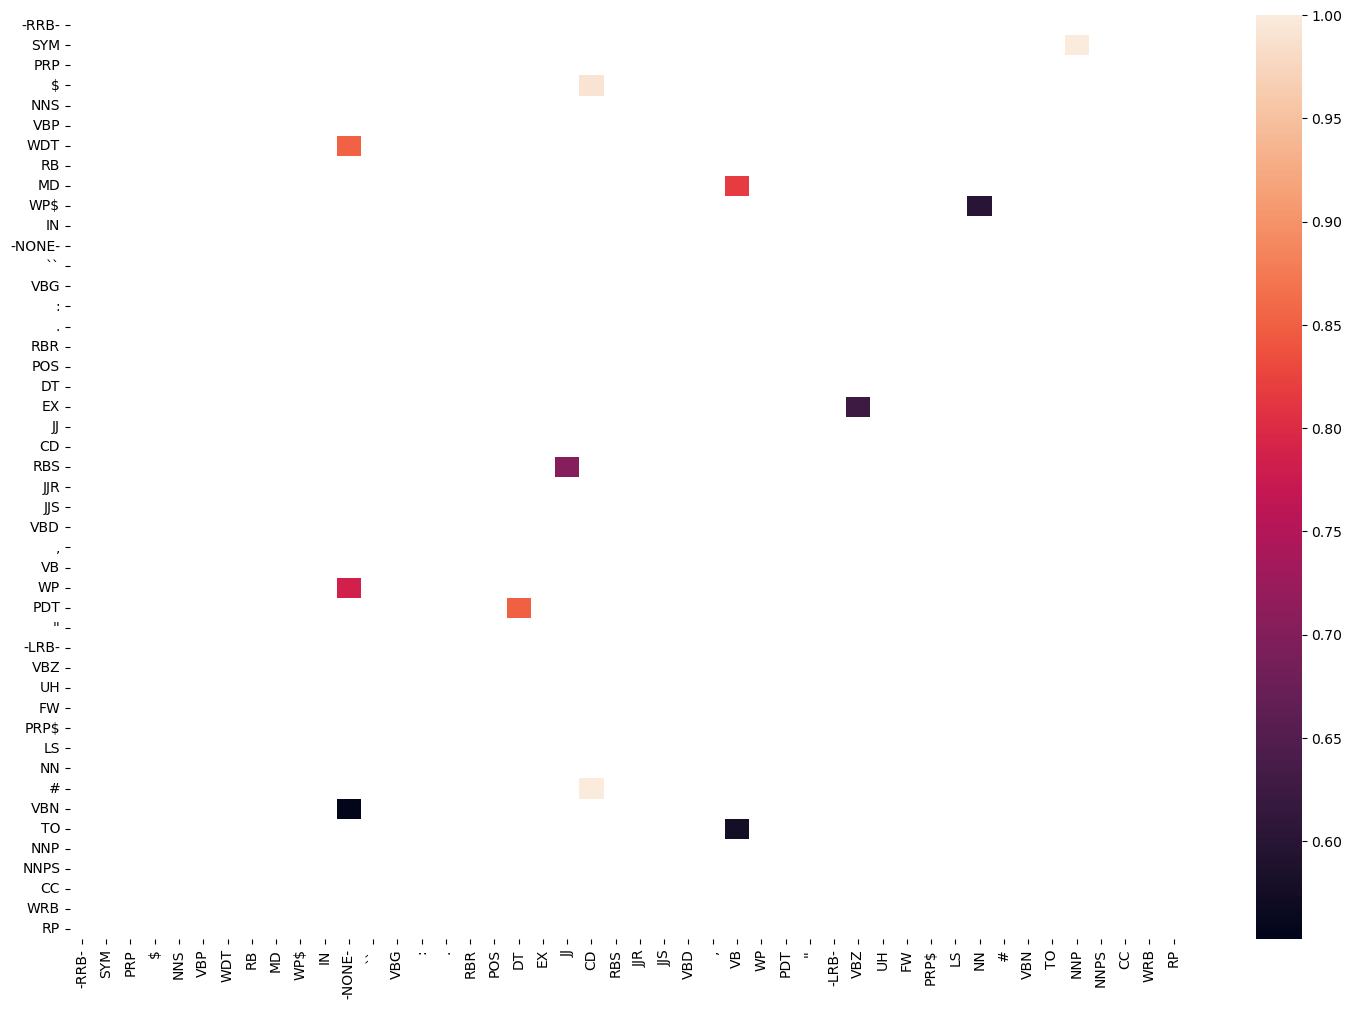

In [28]:
# Frequent tags:
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## 3. Viterbi algorithm 

Let's now use the computed probabilities $P(w|tag)$ and $P(t2, t1)$ to assign tags to each word in the document. We'll run through each word w and compute $P(tag|w)=P(w|tag) \times P(tag)$ for each tag in the tag set, and then assign the tag having the $max P(tag|w)$.

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: $P(tag|start) = P(tag|'.')$

In [30]:
len(train_tagged_words)

70739

In [31]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [32]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run


[[('Michelin', 'NNP'),
  ('Tyre', 'NNP'),
  ('is', 'VBZ'),
  ('a', 'DT'),
  ('unit', 'NN'),
  ('of', 'IN'),
  ('France', 'NNP'),
  ("'s", 'POS'),
  ('Michelin', 'NNP'),
  ('S.A', 'NNP'),
  ('.', '.')],
 [('Despite', 'IN'),
  ('federal', 'JJ'),
  ('disaster', 'NN'),
  ('relief', 'NN'),
  (',', ','),
  ('the', 'DT'),
  ('drought', 'NN'),
  ('of', 'IN'),
  ('1988', 'CD'),
  ('was', 'VBD'),
  ('a', 'DT'),
  ('severe', 'JJ'),
  ('financial', 'JJ'),
  ('setback', 'NN'),
  ('for', 'IN'),
  ('an', 'DT'),
  ('estimated', 'VBN'),
  ('10,000', 'CD'),
  ('to', 'TO'),
  ('15,000', 'CD'),
  ('farmers', 'NNS'),
  (',', ','),
  ('according', 'VBG'),
  ('to', 'TO'),
  ('the', 'DT'),
  ('department', 'NN'),
  ('.', '.')],
 [('*', '-NONE-'),
  ('Beginning', 'VBG'),
  ('in', 'IN'),
  ('1980', 'CD'),
  (',', ','),
  ('courts', 'NNS'),
  ('in', 'IN'),
  ('several', 'JJ'),
  ('states', 'NNS'),
  ('including', 'VBG'),
  ('California', 'NNP'),
  ('and', 'CC'),
  ('New', 'NNP'),
  ('York', 'NNP'),
  ('decided',

## 4. Evaluating on the test set

In [33]:
# Tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [34]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  19.58416771888733
[('Michelin', 'NNP'), ('Tyre', 'NNP'), ('is', 'VBZ'), ('a', 'DT'), ('unit', 'NN'), ('of', 'IN'), ('France', 'NNP'), ("'s", 'POS'), ('Michelin', 'NNP'), ('S.A', '-RRB-'), ('.', '.'), ('Despite', 'IN'), ('federal', 'JJ'), ('disaster', '-RRB-'), ('relief', 'NN'), (',', ','), ('the', 'DT'), ('drought', 'NN'), ('of', 'IN'), ('1988', 'CD'), ('was', 'VBD'), ('a', 'DT'), ('severe', 'JJ'), ('financial', 'JJ'), ('setback', 'NN'), ('for', 'IN'), ('an', 'DT'), ('estimated', 'VBN'), ('10,000', 'CD'), ('to', 'TO'), ('15,000', 'CD'), ('farmers', 'NNS'), (',', ','), ('according', 'VBG'), ('to', 'TO'), ('the', 'DT'), ('department', 'NN'), ('.', '.'), ('*', '-NONE-'), ('Beginning', '-RRB-'), ('in', 'IN'), ('1980', '-RRB-'), (',', ','), ('courts', 'NNS'), ('in', 'IN'), ('several', 'JJ'), ('states', 'NNS'), ('including', 'VBG'), ('California', 'NNP'), ('and', 'CC'), ('New', 'NNP'), ('York', 'NNP'), ('decided', 'VBD'), ('*-2', '-NONE-'), ('to', 'TO'), ('suspend', '

In [35]:
# Accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [36]:
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.8872180451127819


We will now explore the incorrectly tagged cases.

In [37]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [38]:
incorrect_tagged_cases

[[('Michelin', 'NNP'), (('S.A', '-RRB-'), ('S.A', 'NNP'))],
 [('federal', 'JJ'), (('disaster', '-RRB-'), ('disaster', 'NN'))],
 [('*', '-NONE-'), (('Beginning', '-RRB-'), ('Beginning', 'VBG'))],
 [('in', 'IN'), (('1980', '-RRB-'), ('1980', 'CD'))],
 [('the', 'DT'), (('common-law', '-RRB-'), ('common-law', 'NN'))],
 [('to', 'TO'), (('speak', '-RRB-'), ('speak', 'VB'))],
 [('at', 'IN'), (('theological', '-RRB-'), ('theological', 'JJ'))],
 [('theological', 'JJ'), (('colleges', '-RRB-'), ('colleges', 'NNS'))],
 [('the', 'DT'), (('joys', '-RRB-'), ('joys', 'NNS'))],
 [('a', 'DT'), (('booklet', '-RRB-'), ('booklet', 'NN'))],
 [('country', 'NN'), (('entitled', '-RRB-'), ('entitled', 'VBD'))],
 [('The', 'DT'), (('Bells', '-RRB-'), ('Bells', 'NNP'))],
 [('*', '-NONE-'), (('Winning', '-RRB-'), ('Winning', 'VBG'))],
 [("n't", 'RB'), (('that', 'IN'), ('that', 'RB'))],
 [('to', 'TO'), (('her', 'PRP$'), ('her', 'PRP'))]]

In [40]:
## Testing
sentence_test = 'Feminism is a social, political, and economic movement. Feminism is about changing the way that people see male and female rights (mainly female), and campaigning for equal ones. Somebody who follows feminism is called a feminist.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [41]:
print(tagged_seq)
print(difference)

[('Feminism', '-RRB-'), ('is', 'VBZ'), ('a', 'DT'), ('social', 'JJ'), (',', ','), ('political', 'JJ'), (',', ','), ('and', 'CC'), ('economic', 'JJ'), ('movement', 'NN'), ('.', '.'), ('Feminism', '-RRB-'), ('is', 'VBZ'), ('about', 'IN'), ('changing', 'VBG'), ('the', 'DT'), ('way', 'NN'), ('that', 'IN'), ('people', 'NNS'), ('see', 'VBP'), ('male', 'JJ'), ('and', 'CC'), ('female', 'JJ'), ('rights', 'NNS'), ('(', '-RRB-'), ('mainly', 'RB'), ('female', 'JJ'), (')', '-RRB-'), (',', ','), ('and', 'CC'), ('campaigning', 'NN'), ('for', 'IN'), ('equal', 'JJ'), ('ones', 'NNS'), ('.', '.'), ('Somebody', '-RRB-'), ('who', '-RRB-'), ('follows', 'VBZ'), ('feminism', '-RRB-'), ('is', 'VBZ'), ('called', 'VBN'), ('a', 'DT'), ('feminist', '-RRB-'), ('.', '.')]
6.335527181625366


In [42]:
## Testing
sentence_test = 'New feminism is a philosophy similar to equality feminism. It focuses on how the differences between men and women complement each other. New feminism, unlike equality feminism, recognizes the different strengths and roles given to men and women'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start


In [43]:
print(tagged_seq)
print(difference)

[('New', 'NNP'), ('feminism', '-RRB-'), ('is', 'VBZ'), ('a', 'DT'), ('philosophy', '-RRB-'), ('similar', 'JJ'), ('to', 'TO'), ('equality', '-RRB-'), ('feminism', '-RRB-'), ('.', '.'), ('It', 'PRP'), ('focuses', '-RRB-'), ('on', 'IN'), ('how', 'WRB'), ('the', 'DT'), ('differences', 'NNS'), ('between', 'IN'), ('men', 'NNS'), ('and', 'CC'), ('women', 'NNS'), ('complement', '-RRB-'), ('each', 'DT'), ('other', 'JJ'), ('.', '.'), ('New', 'NNP'), ('feminism', '-RRB-'), (',', ','), ('unlike', 'IN'), ('equality', '-RRB-'), ('feminism', '-RRB-'), (',', ','), ('recognizes', '-RRB-'), ('the', 'DT'), ('different', 'JJ'), ('strengths', '-RRB-'), ('and', 'CC'), ('roles', '-RRB-'), ('given', 'VBN'), ('to', 'TO'), ('men', 'NNS'), ('and', 'CC'), ('women', 'NNS')]
6.024113178253174


This tutorial is adapted from the Kaggle tutorial https://www.kaggle.com/code/dhgupta/pos-tagging-hmms-viterbi#3.-Viterbi-Algorithm . All questions and suggestions should be adressed to maria.boritchev@telecom-paris.fr .